Análisis de partidas de Texas Hold'em


Ejemplo de análisis de partidas de Poker

In [114]:
# ======================================
# Comprobaciones y generación de reportes
# ======================================

import pandas as pd
from collections import Counter

# --------------------------------------------------------
# Funciones de evaluación de manos
# --------------------------------------------------------
def straight_high(values):
    vals = set(int(v) for v in values)
    if 14 in vals:
        vals = vals.union({1})
    for start in range(10, 0, -1):
        needed = {start + i for i in range(5)}
        if needed.issubset(vals):
            return start + 4
    return None

def classify_hand(values, suits):
    vals = [int(v) for v in values]
    counts = Counter(vals)
    suit_counts = Counter(int(s) for s in suits)
    flush_suit = next((s for s,cnt in suit_counts.items() if cnt >= 5), None)

    # Escalera Color / Escalera Real
    if flush_suit is not None:
        suited_vals = [v for v,su in zip(vals, suits) if int(su) == int(flush_suit)]
        sh = straight_high(suited_vals)
        if sh is not None:
            if sh == 14 and set([10,11,12,13,14]).issubset(set(int(v) for v in suited_vals)):
                return "Escalera Real"
            return "Escalera Color"

    # Poker
    if 4 in counts.values():
        return "Poker"

    # Full
    has_three = any(c >= 3 for c in counts.values())
    pairs_or_better = sum(1 for c in counts.values() if c >= 2)
    if has_three and pairs_or_better >= 2:
        return "Full"

    # Color
    if flush_suit is not None:
        return "Color"

    # Escalera
    if straight_high(vals) is not None:
        return "Escalera"

    # Trío
    if has_three:
        return "Trio"

    # Doble Pareja
    if sum(1 for c in counts.values() if c >= 2) >= 2:
        return "Doble Pareja"

    # Pareja
    if any(c >= 2 for c in counts.values()):
        return "Pareja"

    return "Carta Alta"

# --------------------------------------------------------
# Función para analizar dataset y generar reportes
# --------------------------------------------------------
def analizar_dataset(csv_path, nombre_salida):
    print(f"\nAnalizando: {csv_path}")
    df = pd.read_csv(csv_path, encoding="utf-8")

    value_cols = [c for c in df.columns if c.startswith("c") and c[1:].isdigit()]
    suit_cols  = [p for p in df.columns if p.startswith("p") and p[1:].isdigit()]

    # Clasificar manos calculadas
    df["clasificacion_calc"] = df.apply(
        lambda r: classify_hand([r[c] for c in value_cols], [r[p] for p in suit_cols]), axis=1
    )

    # ----------------------------------------------------
    # Reporte 1: Inconsistencias en literales
    # ----------------------------------------------------
    df["literal_ok"] = df["literales"].str.strip().str.title() == df["clasificacion_calc"]
    inconsistencias_lit = df[df["literal_ok"] == False]
    inconsistencias_lit.to_csv(f"reporte_inconsistencias_literales_{nombre_salida}.csv", index=False)

    print(f"- Inconsistencias literales: {len(inconsistencias_lit)}")

    # ----------------------------------------------------
    # Reporte 2: Inconsistencias en ganador
    # ----------------------------------------------------
    if "ganador" in df.columns:
        df["gano"] = df["ganador"].astype(str).str.lower().isin(["si","sí"])
        # Ejemplo simple: si la clasificación no es la mejor de la fila
        # (esto es un chequeo preliminar, no desempates complejos)
        counts = df["clasificacion_calc"].value_counts().to_dict()
        # Ranking simple
        rank_value = {
            "Carta Alta": 1, "Pareja": 2, "Doble Pareja": 3, "Trío": 4,
            "Escalera": 5, "Color": 6, "Full": 7, "Poker": 8,
            "Escalera Color": 9, "Escalera Real": 10
        }
        df["rank_num"] = df["clasificacion_calc"].map(rank_value)

        # Máximo rank en cada partida
        inconsistencias_ganador = []
        for partida, grupo in df.groupby("id_partida"):
            max_rank = grupo["rank_num"].max()
            for idx, row in grupo.iterrows():
                if row["gano"] and row["rank_num"] < max_rank:
                    inconsistencias_ganador.append(row)

        inconsistencias_ganador = pd.DataFrame(inconsistencias_ganador)
        inconsistencias_ganador.to_csv(f"reporte_inconsistencias_ganador_{nombre_salida}.csv", index=False)

        print(f"- Inconsistencias ganador: {len(inconsistencias_ganador)}")

    # ----------------------------------------------------
    # Resumen general
    # ----------------------------------------------------
    print("Distribución de jugadas calculadas:")
    print(df["clasificacion_calc"].value_counts())

    return df

# --------------------------------------------------------
# Ejecutar análisis en ambos datasets
# --------------------------------------------------------
df3  = analizar_dataset("partidas_9-YUhppj66fUeugccH9zWXeU.csv", "9")



Analizando: partidas_9-YUhppj66fUeugccH9zWXeU.csv
- Inconsistencias literales: 0
- Inconsistencias ganador: 0
Distribución de jugadas calculadas:
clasificacion_calc
Pareja            98167
Doble Pareja      52620
Carta Alta        39118
Trio              11022
Escalera          10622
Color              7188
Full               5777
Poker               408
Escalera Color       70
Escalera Real         8
Name: count, dtype: int64


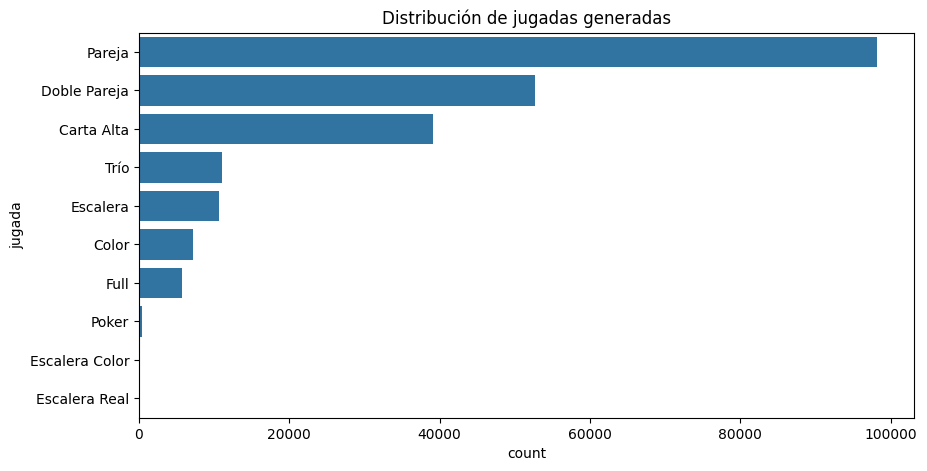

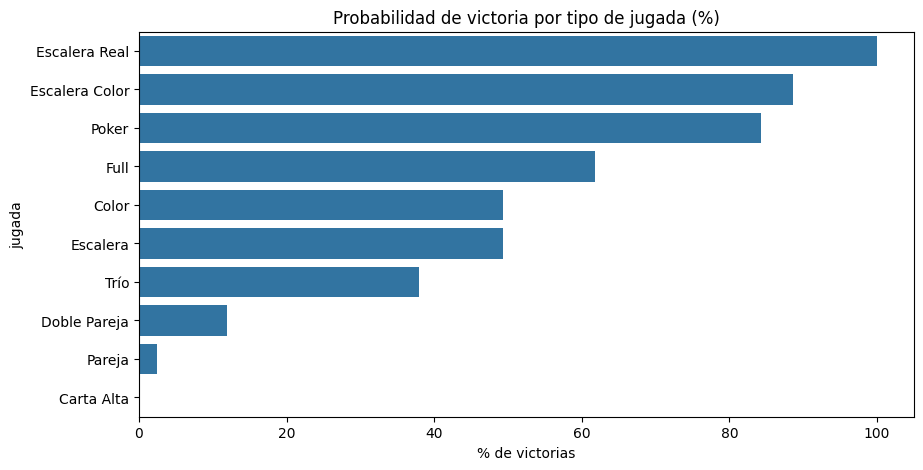

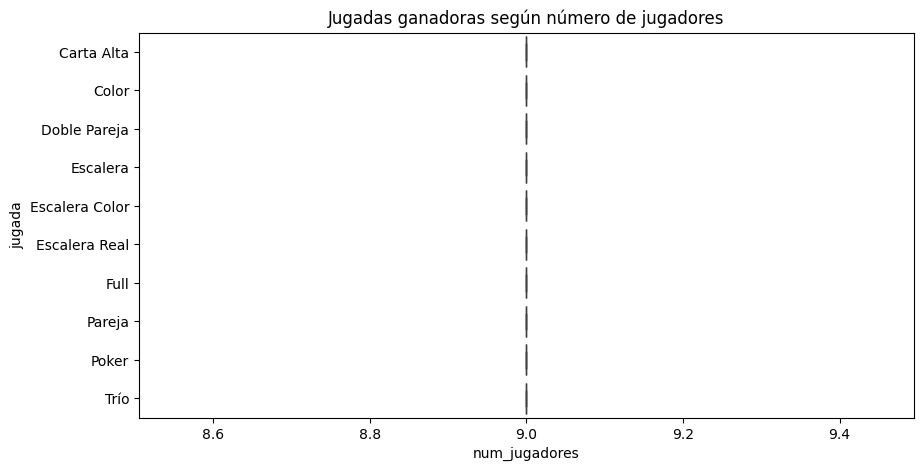

In [115]:
# ======================================
# Ejemplo de análisis de partidas de Poker
# ======================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar dataset (ajusta ruta)
df = pd.read_csv("partidas_9-YUhppj66fUeugccH9zWXeU.csv")

# Normalizar jugadas
mapa = {
    "Trio":"Trío", "trío":"Trío", "esc. color":"Escalera Color",
    "escalera color":"Escalera Color"
}
df["jugada"] = df["literales"].replace(mapa).str.title()

# 1) Distribución de jugadas
plt.figure(figsize=(10,5))
sns.countplot(y="jugada", data=df, order=df["jugada"].value_counts().index)
plt.title("Distribución de jugadas generadas")
plt.show()

# 2) Probabilidad de ganar según jugada
df["gano"] = df["ganador"].astype(str).str.lower().isin(["si","sí"])
win_rates = df.groupby("jugada")["gano"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=win_rates.values*100, y=win_rates.index)
plt.title("Probabilidad de victoria por tipo de jugada (%)")
plt.xlabel("% de victorias")
plt.show()

# 3) (si hay columna num_jugadores) Relación entre número de jugadores y fuerza ganadora
if "num_jugadores" in df.columns:
    ganador_df = df[df["gano"]==True]
    plt.figure(figsize=(10,5))
    sns.boxplot(x="num_jugadores", y="jugada", data=ganador_df,
                order=sorted(df["jugada"].dropna().unique()))
    plt.title("Jugadas ganadoras según número de jugadores")
    plt.show()


Filas: 225000
Columnas: ['Unnamed: 0', 'literales', 'unidad', 'puntos', 'jugadores', 'carta', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7'] ...
Valores: ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
Palos: ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']
Ejemplo de clasificaciones:
  clasificacion
0          Trío
1  Doble Pareja
2  Doble Pareja
3        Pareja
4        Pareja


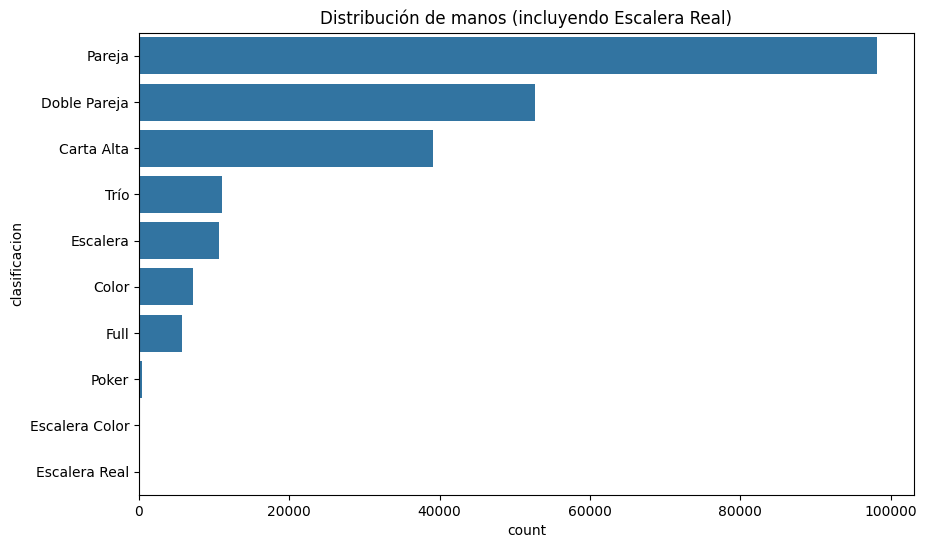

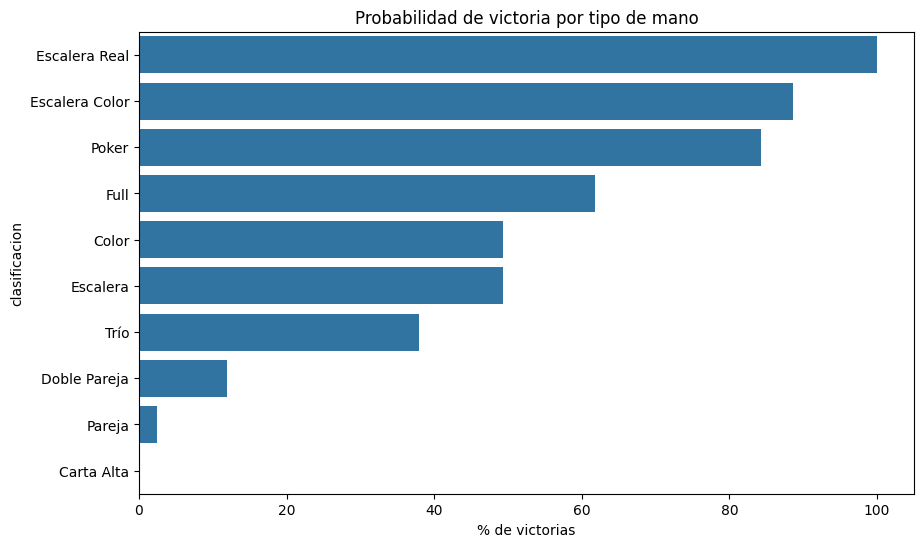

Escaleras Reales encontradas: 8 (0.003556%)


In [116]:
# ======================================
# Análisis de partidas de Poker Texas Hold'em
# Incluye corrección: detección de Escalera Real
# ======================================

import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1) Cargar dataset
# --------------------------------------------------------
# Subir el CSV al entorno de Colab o usar Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

CSV_PATH = "partidas_9-YUhppj66fUeugccH9zWXeU.csv"  # <-- cambiar a partidas_10.csv si es necesario
df = pd.read_csv(CSV_PATH, encoding="utf-8")

print("Filas:", len(df))
print("Columnas:", df.columns.tolist()[:20], "...")

# --------------------------------------------------------
# 2) Detectar columnas de cartas y palos
# --------------------------------------------------------
value_cols = [c for c in df.columns if c.startswith("c") and c[1:].isdigit()]
suit_cols  = [p for p in df.columns if p.startswith("p") and p[1:].isdigit()]

print("Valores:", value_cols)
print("Palos:", suit_cols)

# --------------------------------------------------------
# 3) Funciones de clasificación de manos
# --------------------------------------------------------
rank_map = {
    1: "Carta Alta", 2: "Pareja", 3: "Doble Pareja", 4: "Trío",
    5: "Escalera", 6: "Color", 7: "Full", 8: "Poker",
    9: "Escalera Color", 10: "Escalera Real"
}
rank_map_inv = {v:k for k,v in rank_map.items()}

def straight_high(values):
    """Devuelve la carta más alta de una escalera (A=14 también puede ser 1)."""
    vals = set(int(v) for v in values)
    if 14 in vals:
        vals = vals.union({1})
    for start in range(10, 0, -1):
        needed = {start + i for i in range(5)}
        if needed.issubset(vals):
            return start + 4
    return None

def classify_hand(values, suits):
    vals = [int(v) for v in values]
    counts = Counter(vals)
    suit_counts = Counter(int(s) for s in suits)
    flush_suit = next((s for s,cnt in suit_counts.items() if cnt >= 5), None)

    # Escalera Color / Escalera Real
    if flush_suit is not None:
        suited_vals = [v for v,su in zip(vals, suits) if int(su) == int(flush_suit)]
        sh = straight_high(suited_vals)
        if sh is not None:
            if sh == 14 and set([10,11,12,13,14]).issubset(set(int(v) for v in suited_vals)):
                return "Escalera Real"
            return "Escalera Color"

    # Poker
    if 4 in counts.values():
        return "Poker"

    # Full (Trío + Pareja)
    has_three = any(c >= 3 for c in counts.values())
    pairs_or_better = sum(1 for c in counts.values() if c >= 2)
    if has_three and pairs_or_better >= 2:
        return "Full"

    # Color
    if flush_suit is not None:
        return "Color"

    # Escalera
    if straight_high(vals) is not None:
        return "Escalera"

    # Trío
    if has_three:
        return "Trío"

    # Doble Pareja
    if sum(1 for c in counts.values() if c >= 2) >= 2:
        return "Doble Pareja"

    # Pareja
    if any(c >= 2 for c in counts.values()):
        return "Pareja"

    return "Carta Alta"

# --------------------------------------------------------
# 4) Clasificar manos y añadir al dataframe
# --------------------------------------------------------
df["clasificacion"] = df.apply(lambda r: classify_hand([r[c] for c in value_cols],
                                                       [r[p] for p in suit_cols]), axis=1)

print("Ejemplo de clasificaciones:")
print(df[["clasificacion"]].head())

# --------------------------------------------------------
# 5) Distribución de jugadas
# --------------------------------------------------------
plt.figure(figsize=(10,6))
order = df["clasificacion"].value_counts().index
sns.countplot(y="clasificacion", data=df, order=order)
plt.title("Distribución de manos (incluyendo Escalera Real)")
plt.show()

# --------------------------------------------------------
# 6) Probabilidad de victoria por tipo de mano
# --------------------------------------------------------
if "ganador" in df.columns:
    df["gano"] = df["ganador"].astype(str).str.lower().isin(["si","sí"])
    win_rates = df.groupby("clasificacion")["gano"].mean().sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=win_rates.values*100, y=win_rates.index)
    plt.xlabel("% de victorias")
    plt.title("Probabilidad de victoria por tipo de mano")
    plt.show()

# --------------------------------------------------------
# 7) Mostrar rareza de Escalera Real
# --------------------------------------------------------
count_real = (df["clasificacion"] == "Escalera Real").sum()
print(f"Escaleras Reales encontradas: {count_real} ({100*count_real/len(df):.6f}%)")
